In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

/home/luissimaoaf/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# USD/EUR Spot Foreign Exchange Rate
usd_eur = pdr.data.DataReader(
    name='DEXUSEU',
    data_source='fred',
)

# Secured Overnight Financing Rate
overnight_rate = pdr.data.DataReader(
    name='SOFR',
    data_source='fred'
)

# Treasury Securities Sold by the Federal Reserve in the Temporary Open Market Operations 
market_ops = pdr.data.DataReader(
    name='RRPONTSYD',
    data_source='fred'
)

# ECB Deposit Facility Rate for Euro Area
ecb_rate = pdr.data.DataReader(
    name='ECBDFR',
    data_source='fred'
)

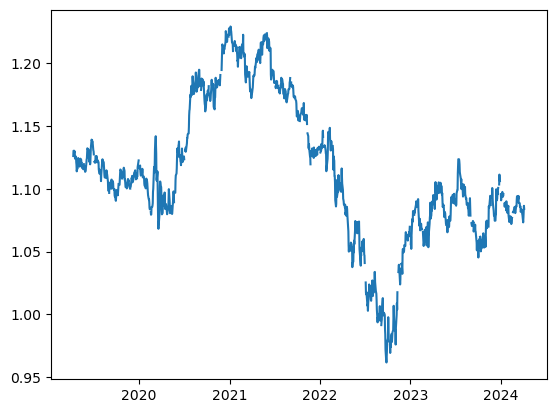

In [4]:
plt.plot(usd_eur)

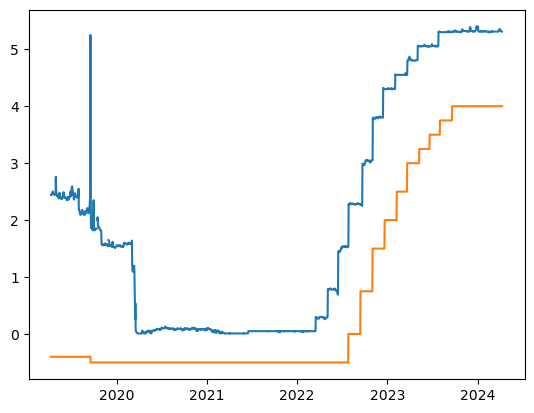

In [5]:
plt.plot(overnight_rate)
plt.plot(ecb_rate)

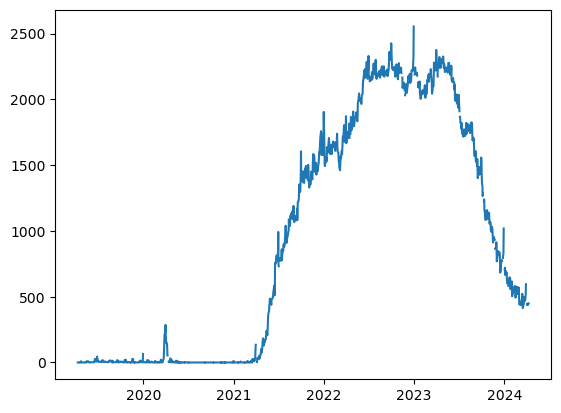

In [6]:
plt.plot(market_ops)

## Preprocessing

In [7]:
merged_df = overnight_rate.merge(
    right=ecb_rate,
    left_index=True,
    right_index=True
    )

merged_df = merged_df.merge(
    right=market_ops,
    left_index=True,
    right_index=True
)

merged_df = merged_df.merge(
    right=usd_eur,
    left_index=True,
    right_index=True
)

In [8]:
# removing NaN values by interpolating
merged_df = merged_df.interpolate()

merged_df.reset_index(inplace=True)
merged_df.drop(columns=["DATE"],inplace=True)

In [9]:
# how far ahead we are trying to predict
look_ahead = 7
# how many splits in the data for cross validation
splits = 10

merged_df['Target'] = merged_df['DEXUSEU'].shift(-look_ahead)
merged_df.dropna()

predictors = ['SOFR', 'ECBDFR', 'RRPONTSYD', 'DEXUSEU']

,SOFR,ECBDFR,RRPONTSYD,DEXUSEU
0,0.212357,-0.593561,-1.028035,0.228307
1,0.212357,-0.593561,-1.028153,0.302364
2,0.226916,-0.593561,-1.028151,0.302364
3,0.226916,-0.593561,-1.027393,0.282968
4,0.241475,-0.593561,-1.028154,0.290021
...,...,...,...,...
1297,1.624588,1.949360,-0.536873,-0.704459
1298,1.619735,1.949360,-0.529623,-0.640982
1299,1.610029,1.949360,-0.542734,-0.538713
1300,1.610029,1.949360,-0.540363,-0.471709


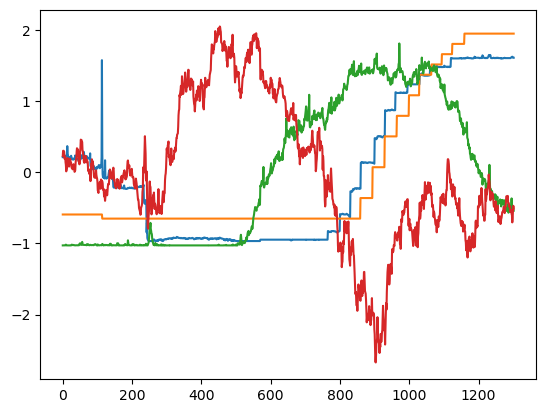

In [10]:
from sklearn.preprocessing import StandardScaler

# scaling the data
scaled_df = merged_df.loc[:,predictors]
scaler = StandardScaler()
scaler.fit(scaled_df)

scaled_df = pd.DataFrame(
    scaler.transform(scaled_df),
    index=merged_df.index,
    columns=predictors
    )
plt.plot(scaled_df)
scaled_df

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(
    gap=look_ahead+3,
    n_splits=splits
)

model_accuracy = np.zeros(splits)
our_metric = mean_absolute_percentage_error

for i, (train, test) in enumerate(tscv.split(merged_df)):
    model = LinearRegression()
    model.fit(
        scaled_df.loc[train[0]:train[-1], predictors],
        merged_df.loc[train[0]:train[-1], 'Target']
    )
    model_accuracy[i] = (
        our_metric(
            merged_df.loc[train[0]:train[-1], 'Target'],
            model.predict(scaled_df.loc[train[0]:train[-1], predictors])
        )
    )

{'whiskers': [<matplotlib.lines.Line2D at 0x7f47312b6e50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f47312c4450>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f47312b6190>],
 'medians': [<matplotlib.lines.Line2D at 0x7f47312c5990>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f47312c6490>],
 'means': []}

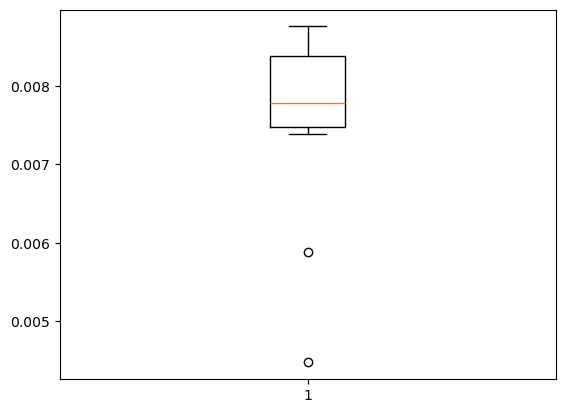

In [12]:
plt.boxplot(model_accuracy)

In [33]:

pct_ret = (
    (merged_df['DEXUSEU'][1:].values - merged_df['DEXUSEU'][:-1].values)/     merged_df['DEXUSEU'][:-1].values
)

pct_ret.mean()*30

-0.0005832686906870392